# Test ASDETECT Run Environment

Sources:
* https://medium.com/@mflova/making-python-extremely-fast-with-numba-advanced-deep-dive-1-3-4d303edeede4

## Classic ASDETECT (no numba)

In [1]:
import numpy as np
import numba
import timeit


import toad
from toad.shifts_detection.methods.asdetect import ASDETECT

### Show Function

In [2]:
fp1 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td1 = toad.TOAD(fp1)

# Setup
lat_coarsen = 1
lon_coarsen = 1
time_coarsen = 3
td1.data = td1.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()

td1.compute_shifts("thk", ASDETECT(), overwrite=True)

shifts1 = td1.get_shifts("thk")
mean1 = shifts1.mean().values
std1 = shifts1.std().values

print(f"Mean: {mean1}")
print(f"Std: {std1}")

Mean: -0.07718787342309952
Std: 0.22043025493621826


In [3]:
# from sklearn.cluster import HDBSCAN  Could use the one from sklearn, but below is faster
from fast_hdbscan import HDBSCAN

# Minimum required input is a variable name, a method and a filtering function.
td1.compute_clusters(
    var="thk",  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=10),
    shifts_filter_func=lambda x: np.abs(x)
    > 0.8,  # toad will cluster the points that pass this filter
)


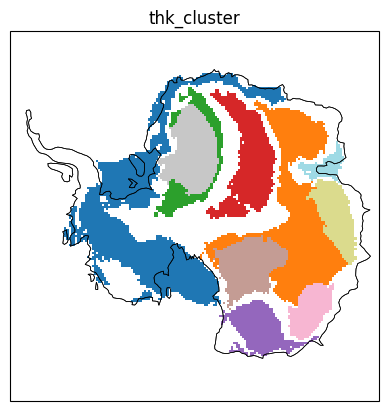

In [4]:
fig, ax = td1.plotter().south_pole_plots(grid_labels=False)
td1.plotter().plot_clusters_on_map(
    "thk", ax=ax, cluster_ids=range(10)
);  # plot 10 largest clusters

### Time It

In [ ]:
setup = '''
import toad
from toad.shifts_detection.methods.asdetect import ASDETECT

fp1 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td1 = toad.TOAD(fp1)

# Setup
lat_coarsen = 10
lon_coarsen = 10
time_coarsen = 3
td1.data = td1.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()
'''

code = '''
td1.compute_shifts("thk", ASDETECT(), overwrite=True)
'''

iterations = 10
time = timeit.timeit(setup=setup, stmt=code, number=iterations)
print(f"Avg. Time: {time/iterations}")

Avg. Time: 9.05331685669953


## Advanced ASDETECT (with numba)

In [5]:
import numpy as np
import numba
import timeit

import toad
from toad.shifts_detection.methods.asdetect_numba import ASDETECT as ASDETECT_Numba

### Show Function

In [6]:
fp2 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td2 = toad.TOAD(fp1)

# Setup
lat_coarsen = 1
lon_coarsen = 1
time_coarsen = 3
td2.data = td2.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()

td2.compute_shifts("thk", ASDETECT_Numba(), overwrite=True)

shifts2 = td2.get_shifts("thk")
mean2 = shifts2.mean().values
std2 = shifts2.std().values

print(f"Mean: {mean2}")
print(f"Std: {std2}")

Mean: -0.07720167189836502
Std: 0.2204473614692688


In [7]:
# from sklearn.cluster import HDBSCAN  Could use the one from sklearn, but below is faster
from fast_hdbscan import HDBSCAN

# Minimum required input is a variable name, a method and a filtering function.
td2.compute_clusters(
    var="thk",  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=10),
    shifts_filter_func=lambda x: np.abs(x)
    > 0.8,  # toad will cluster the points that pass this filter
)


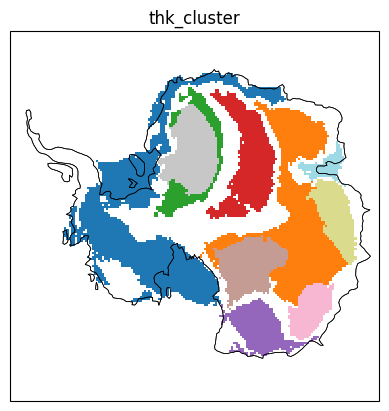

In [8]:
fig, ax = td2.plotter().south_pole_plots(grid_labels=False)
td2.plotter().plot_clusters_on_map(
    "thk", ax=ax, cluster_ids=range(10)
);  # plot 10 largest clusters

### Time It

In [22]:
setup = '''
import toad
from toad.shifts_detection.methods.asdetect_numba import ASDETECT as ASDETECT_Numba

fp1 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td1 = toad.TOAD(fp1)

# Setup
lat_coarsen = 10
lon_coarsen = 10
time_coarsen = 3
td1.data = td1.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()
'''

code = '''
td1.compute_shifts("thk", ASDETECT_Numba(), overwrite=True)
'''

iterations = 100
time = timeit.timeit(setup=setup, stmt=code, number=iterations)
print(f"Avg. Time: {time/iterations}")

Avg. Time: 6.885140798500069


## Advanced ASDETECT (with numba) - second solution

In [65]:
import numpy as np
import numba
import timeit

import toad
from toad.shifts_detection.methods.asdetect_numba2 import ASDETECT as ASDETECT_Numba

### Show Function

In [67]:
fp3 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td3 = toad.TOAD(fp3)

# Setup
lat_coarsen = 10
lon_coarsen = 10
time_coarsen = 3
td3.data = td3.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()

td3.compute_shifts("thk", ASDETECT_Numba(), overwrite=True)

shifts3 = td3.get_shifts("thk")
mean3 = shifts3.mean().values
std3 = shifts3.std().values

print(f"Mean: {mean3}")
print(f"Std: {std3}")

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_gradients': Cannot determine Numba type of <class 'function'>

File "toad/shifts_detection/methods/asdetect_numba2.py", line 200:
def construct_detection_ts(
    <source elided>
        # of the resulting distribution
        gradients = compute_gradients(t_segs, arr_segs)
        ^

During: Pass nopython_type_inference

In [ ]:
# from sklearn.cluster import HDBSCAN  Could use the one from sklearn, but below is faster
from fast_hdbscan import HDBSCAN

# Minimum required input is a variable name, a method and a filtering function.
td3.compute_clusters(
    var="thk",  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=10),
    shifts_filter_func=lambda x: np.abs(x)
    > 0.8,  # toad will cluster the points that pass this filter
)


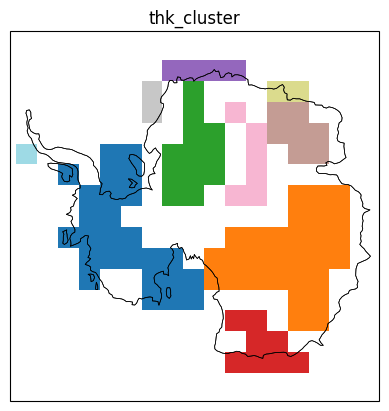

In [ ]:
fig, ax = td3.plotter().south_pole_plots(grid_labels=False)
td3.plotter().plot_clusters_on_map(
    "thk", ax=ax, cluster_ids=range(10)
);  # plot 10 largest clusters

### Time It

In [27]:
setup = '''
import toad
from toad.shifts_detection.methods.asdetect_numba2 import ASDETECT as ASDETECT_Numba

fp1 = "./tutorials/test_data/garbe_2020_antarctica.nc"
td1 = toad.TOAD(fp1)

# Setup
lat_coarsen = 10
lon_coarsen = 10
time_coarsen = 3
td1.data = td1.data.coarsen(
    x=lat_coarsen,
    y=lon_coarsen,
    time=time_coarsen,
    boundary="trim",
).mean()
'''

code = '''
td1.compute_shifts("thk", ASDETECT_Numba(), overwrite=True)
'''

iterations = 100
time = timeit.timeit(setup=setup, stmt=code, number=iterations)
print(f"Avg. Time: {time/iterations}")

Avg. Time: 9.041846557769896


## Compare Results

In [9]:
print("Method Numba 1:")
if shifts1.equals(shifts2):
    print("Methods equal: YES")
else:
    print("Methods equal: NO")

#print("\nMethod Numba 2:")
#if shifts1.equals(shifts3):
#    print("Methods equal: YES")
#else:
#    print("Methods equal: NO")

Method Numba 1:
Methods equal: NO


In [13]:
td1_copy = td1.data.copy()
td2_copy = td2.data.copy()

In [33]:
from toad import TOAD

td1 = TOAD(td1_copy)
td2 = TOAD(td2_copy)

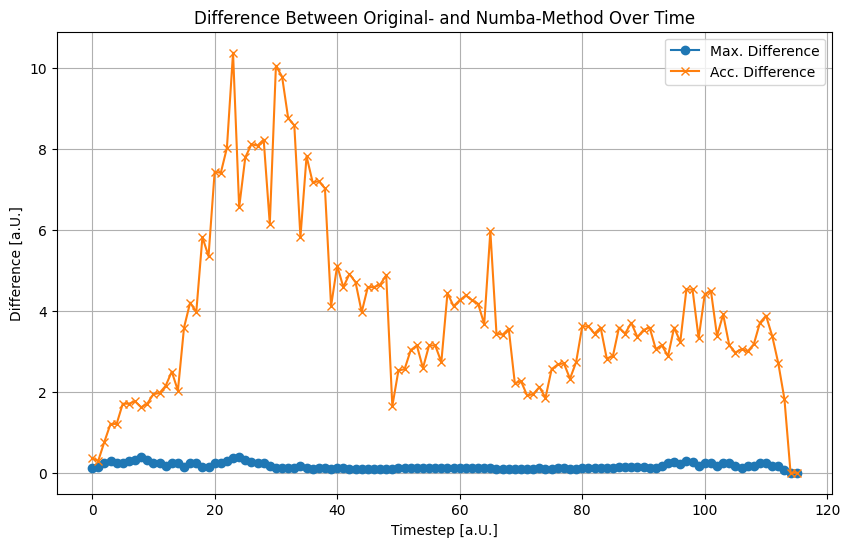

In [34]:
# Compute the difference between shifts1 and shifts2
difference = shifts1 - shifts2

import matplotlib.pyplot as plt
# Compute the maximum difference for each time step
max_difference = np.abs(difference).max(dim=['x', 'y']).values
# Compute the sum of differences for each time step
sum_difference = np.abs(difference).sum(dim=['x', 'y']).values

# Plot the maximum difference over time
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(difference.time)), max_difference, marker='o', label='Max. Difference')
plt.plot(np.arange(0,len(difference.time)), sum_difference, marker='x', label='Acc. Difference')
plt.xlabel('Timestep [a.U.]')
plt.ylabel('Difference [a.U.]')
plt.title('Difference Between Original- and Numba-Method Over Time')
plt.grid(True)
plt.legend()

plt.show()

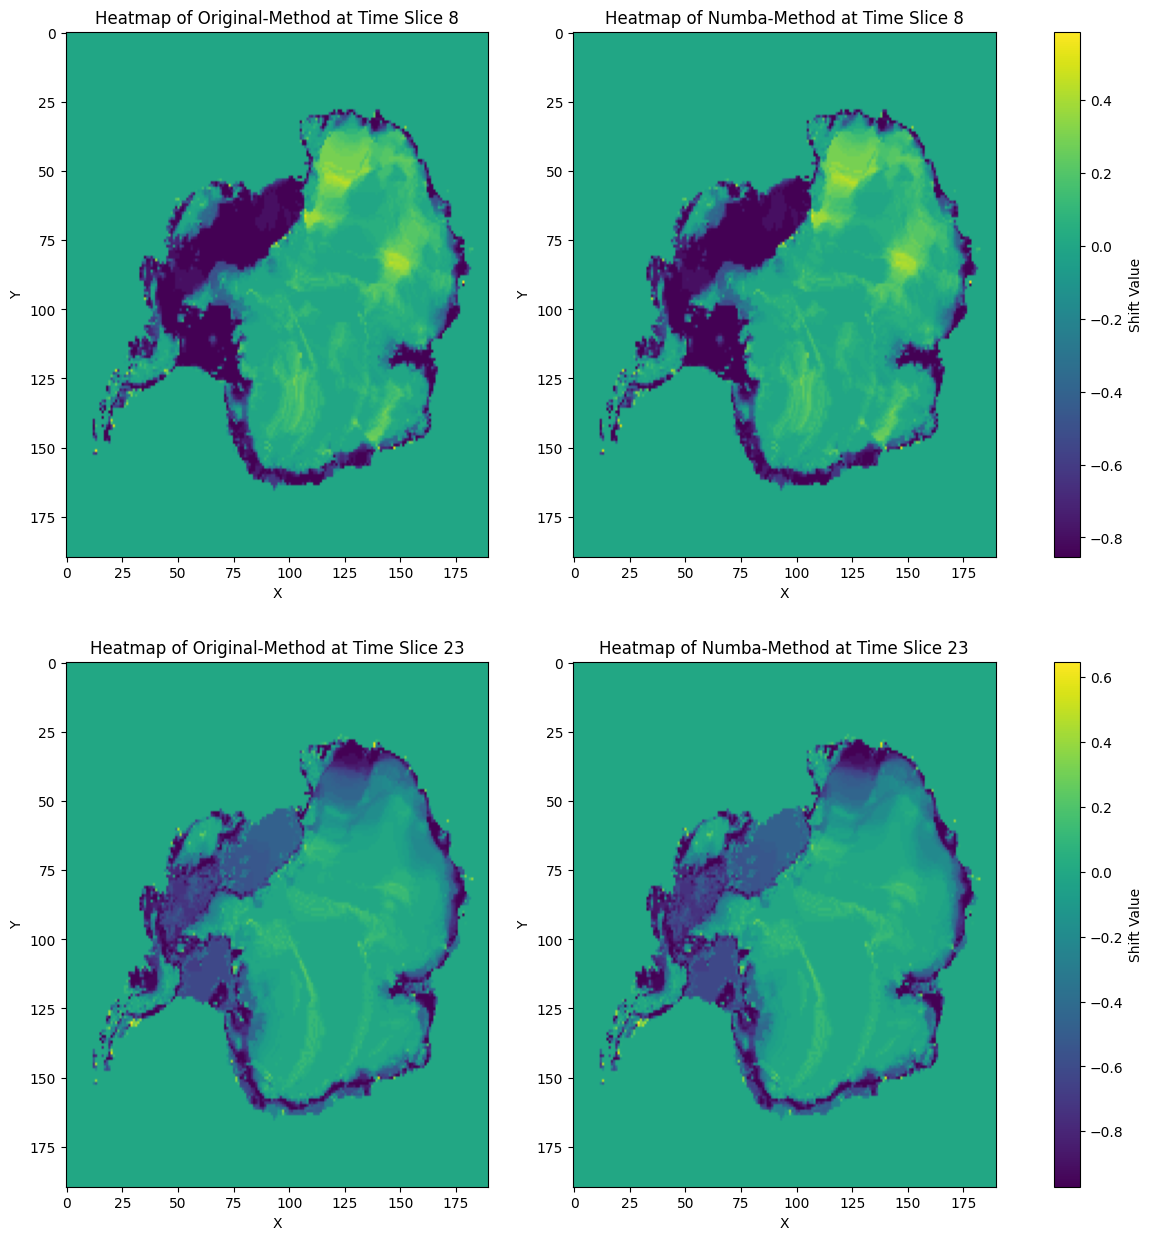

In [35]:
import matplotlib.pyplot as plt

max_max_difference_ix = np.argmax(max_difference)
max_sum_difference_ix = np.argmax(sum_difference)

# Select a specific time slice for visualization
time_slice1 = max_max_difference_ix
time_slice2 = max_sum_difference_ix

data1 = shifts1.isel(time=time_slice1).values
data2 = shifts2.isel(time=time_slice1).values

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot for shifts1 at time_slice1
im1 = axes[0,0].imshow(shifts1.isel(time=time_slice1).values, cmap="viridis", aspect='auto')
axes[0,0].set_title(f"Heatmap of Original-Method at Time Slice {time_slice1}")
axes[0,0].set_xlabel("X")
axes[0,0].set_ylabel("Y")

# Plot for shifts2 at time_slice1
im2 = axes[0,1].imshow(shifts2.isel(time=time_slice1).values, cmap="viridis", aspect='auto')
axes[0,1].set_title(f"Heatmap of Numba-Method at Time Slice {time_slice1}")
axes[0,1].set_xlabel("X")
axes[0,1].set_ylabel("Y")

# Add shared colorbar for the first row
fig.colorbar(im1, ax=axes[0, :], orientation='vertical', label='Shift Value')

# Plot for shifts1 at time_slice2
im3 = axes[1,0].imshow(shifts1.isel(time=time_slice2).values, cmap="viridis", aspect='auto')
axes[1,0].set_title(f"Heatmap of Original-Method at Time Slice {time_slice2}")
axes[1,0].set_xlabel("X")
axes[1,0].set_ylabel("Y")

# Plot for shifts2 at time_slice2
im4 = axes[1,1].imshow(shifts2.isel(time=time_slice2).values, cmap="viridis", aspect='auto')
axes[1,1].set_title(f"Heatmap of Numba-Method at Time Slice {time_slice2}")
axes[1,1].set_xlabel("X")
axes[1,1].set_ylabel("Y")

# Add shared colorbar for the second row
fig.colorbar(im3, ax=axes[1, :], orientation='vertical', label='Shift Value')

#plt.tight_layout()
plt.show()


In [52]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import HDBSCAN
from sklearn.base import ClusterMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler

from toad.clustering.prepare_data import prepare_dataframe
from typing import Callable
from typing import Optional, Union
from matplotlib.colors import ListedColormap
import inspect
import logging

logger = logging.getLogger("TOAD")

class CELL_COMPARE():

    def __init__(self,
            td1 : xr.Dataset,
            td2 : xr.Dataset,
            var : Optional[str] ='thk',
    ):
        
        cid1 = np.array(td1[f'{var}_cluster'])
        cid2 = np.array(td2[f'{var}_cluster'])

        # Flatten the arrays to 1D for easier processing
        fid1 = cid1.flatten()
        fid2 = cid2.flatten()

        # Get the unique values in both arrays
        self.unique_values1 = np.unique(fid1)
        self.unique_values2 = np.unique(fid2)

        # Initialize the heatmap matrix
        self.heatmap = np.zeros((len(self.unique_values2), len(self.unique_values1)))

        # Populate the heatmap matrix
        for i, val1 in enumerate(self.unique_values1):                               # column index
            for j, val2 in enumerate(self.unique_values2):                           # row index
                self.heatmap[j, i] = np.sum((fid1 == val1) & (fid2 == val2))

    def plotter(self,
            title : Optional[str] = None,
            figsize : Optional[tuple] = (8,6),
            xlabel : Optional[str] = "Cluster ID dataset 1",
            ylabel : Optional[str] = "Cluster ID dataset 2",
    ):
        # Log base 10 scale transformation to reduce the impact of large values
        log_heatmap_data = np.log10(self.heatmap + 1)                           # log10+1 ensures no log(0) issues
        # plot
        plt.figure(figsize=figsize)
        ax = sns.heatmap(
            log_heatmap_data, 
            annot=True, 
            fmt=".1f", 
            xticklabels=self.unique_values1, 
            yticklabels=self.unique_values2, 
            cmap="viridis"
        )
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.show()

    def mean_fragmentation(self,
                           ):
        # ignore first row and column of heatmaps; per column, count the number of entries that are not zero
        try:
            col_nonzero = np.where(self.heatmap[1:,1:] != 0)[1]                                             # list of columns indices for each entry not zero
            unique, counts = np.unique(col_nonzero, return_counts=True)                                     # unique values and their counts

            counts_full = np.zeros(len(self.heatmap[1,1:]))
            counts_full[unique] = counts 
            weighted_mean = np.average(counts_full,weights=np.sum(self.heatmap[1:,1:],axis=0,dtype=int))    # weighted mean of counts with total number of cells per column as weights
        except:
            weighted_mean = np.nan

        return weighted_mean

    def mean_unification(self,
                         ):
        # ignore first row and column of heatmaps; per row, count the number of entries that are not zero
        try:
            row_nonzero = np.where(self.heatmap[1:,1:] != 0)[0]                                             # list of rows indices for each entry not zero
            unique, counts = np.unique(row_nonzero, return_counts=True)                                     # unique values and their counts

            counts_full = np.zeros(len(self.heatmap[1:,1:]))
            counts_full[unique] = counts 
            weighted_mean = np.average(counts_full,weights=np.sum(self.heatmap[1:,1:],axis=1,dtype=int))    # weighted mean of counts with total number of cells per column as weights
        except:
            weighted_mean = np.nan

        return weighted_mean

In [53]:
# parameters
threshold = 0.1
min_cluster_size = 10
time_ix_start = 0       # min=0, inclusive
time_ix_end = 116        # max=86, exclusive

In [54]:
# Select a specific time slice for visualization
time_slice = 23  # You can change this to the desired time index

print(td1.data.isel(time=time_slice))

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 190, x: 190)
Coordinates:
    time         float64 8B 2.83e+04
  * x            (x) float64 2kB -3.032e+06 -3e+06 ... 2.984e+06 3.016e+06
  * y            (y) float64 2kB -3.032e+06 -3e+06 ... 2.984e+06 3.016e+06
    lat          (y, x) float64 289kB -51.94 -52.13 -52.32 ... -52.32 -52.13
    lon          (y, x) float64 289kB -135.0 -135.3 -135.6 ... 44.39 44.69 45.0
Data variables:
    thk          (y, x) float32 144kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_dts      (y, x) float32 144kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_cluster  (y, x) int64 289kB -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed 

In [58]:
wrong_CC = np.zeros((time_ix_end-time_ix_start,1))
wrong_NC = np.zeros((time_ix_end-time_ix_start,1))
mean_frag = np.zeros((time_ix_end-time_ix_start,1))
mean_unif = np.zeros((time_ix_end-time_ix_start,1))

for time_ix in range(time_ix_start,time_ix_end):
    print(f"Processing time index {time_ix}/{time_ix_end-1}...",end="\r")
    running_ix = time_ix - time_ix_start

    temp1 = xr.Dataset(td1.data.isel(time=time_ix)[["thk_cluster"]])
    temp2 = xr.Dataset(td2.data.isel(time=time_ix)[["thk_cluster"]])
    #print(type(temp1))
    #print(temp2['thk_cluster'])

    # compare B to A, D and E
    OriginVsNumba = CELL_COMPARE(temp1,temp2)

    # get total number of noise cells of td_B
    Origin_noise_tot = int(np.sum(temp1['thk_cluster'] == -1))

    # get wrongly assigned noise cells
    wrong_CC[running_ix] = np.array([OriginVsNumba.heatmap[0,1:].sum()])/Origin_noise_tot   # wrong Cluster Cells
    wrong_NC[running_ix] = np.array([OriginVsNumba.heatmap[1:,0].sum()])/Origin_noise_tot   # wrong Noise Cells

    # get mean fragmentation and unification
    mean_frag[running_ix] = np.array([OriginVsNumba.mean_fragmentation()])
    mean_unif[running_ix] = np.array([OriginVsNumba.mean_unification(),])   


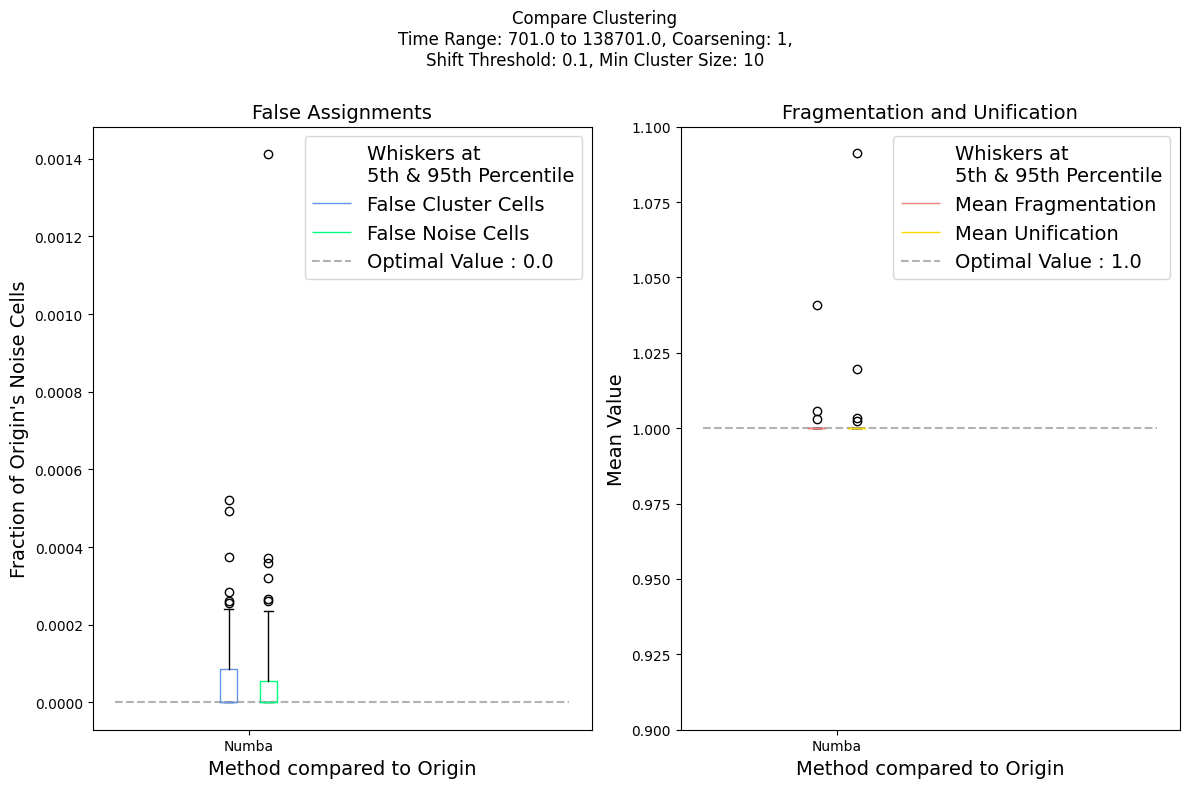

In [76]:


import matplotlib.pyplot as plt
import numpy as np

# bar plot of wrong assignments
fig,ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle(f"Compare Clustering\n"
             + f"Time Range: {td1_copy.time[time_ix_start].values} to {td1_copy.time[time_ix_end-1].values}, Coarsening: {1},\n"
             + f"Shift Threshold: {threshold}, Min Cluster Size: {min_cluster_size}\n")

# left plot: wrong assignments
box_width = 0.35
index = np.arange(1)

# bar 1
ax[0].plot(0,0,linestyle='',label='Whiskers at\n5th & 95th Percentile')
ax[0].boxplot(wrong_CC,
              whis=(5, 95),
              tick_labels=['Numba'],
              positions=index,
              label='False Cluster Cells',
              boxprops=dict(color='cornflowerblue'),
              medianprops=dict(color='cornflowerblue'),
              )
# bar 2
ax[0].boxplot(wrong_NC,
              whis=(5, 95),
              tick_labels=['Numba'],
              positions=index+box_width,
              label='False Noise Cells',
              boxprops=dict(color='springgreen'),
              medianprops=dict(color='springgreen'),
              )
ax[0].hlines(0.0, -1, 3,
             linestyle='--',
             colors='grey',
             alpha=0.6,
             label='Optimal Value : 0.0')

ax[0].set_xlabel('Method compared to Origin',fontsize=14)
ax[0].set_ylabel('Fraction of Origin\'s Noise Cells',fontsize=14)
ax[0].set_title('False Assignments',fontsize=14)
ax[0].set_xticks(index + box_width / 2)
ax[0].legend(loc='upper right',fontsize=14)

# right plot: mean fragmentation and unification
bar_width = 0.35
index = np.arange(1)

# bar 1
# filter nan values of mean_frag
mean_frag = mean_frag[~np.isnan(mean_frag).any(axis=1)]
ax[1].plot(0,0,linestyle='',label='Whiskers at\n5th & 95th Percentile')
ax[1].boxplot(mean_frag,
              whis=(5, 95),
              tick_labels=['Numba'],
              positions=index,
              label='Mean Fragmentation',
              boxprops=dict(color='lightcoral'),
              medianprops=dict(color='lightcoral'),
              )
# bar 2
mean_unif = mean_unif[~np.isnan(mean_unif).any(axis=1)]
ax[1].boxplot(mean_unif,
              whis=(5, 95),
              tick_labels=['Numba'],
              positions=index+box_width,
              label='Mean Unification',
              boxprops=dict(color='gold'),
              medianprops=dict(color='gold'),
              )
ax[1].hlines(1.0, -1, 3,
             linestyle='--',
             colors='grey',
             alpha=0.6,
             label='Optimal Value : 1.0')

ax[1].set_xlabel('Method compared to Origin',fontsize=14)
ax[1].set_ylabel('Mean Value',fontsize=14)
ax[1].set_title('Fragmentation and Unification',fontsize=14)
ax[1].set_xticks(index + box_width / 2)
ax[1].set_ylim(0.9,1.1)
ax[1].legend(loc='upper right',fontsize=14)

plt.tight_layout()
plt.show()



## Numba Polyfit

As numpy.polyfit is not ... with numba, we need a custom version of this function.

In [12]:
from toad.shifts_detection.methods.polyfit_numba import polyfit
from numpy import polyfit as np_polyfit, linspace, cos, random

# Create Dummy Data and use existing numpy polyfit as test
x = linspace(0, 2, 20)   
y = cos(x) + 0.3*random.rand(20)
p = np_polyfit(x, y, 3)

t = linspace(0, 2, 200)

# Now plot using the Numba (amazing) functions
p_coeffs = polyfit(x, y, deg=3)

print(f"Original Coefficients: {p}")
print(f"Numba Coefficients: {p_coeffs}")

Original Coefficients: [ 0.02510688 -0.33781648 -0.19481357  1.17018815]
Numba Coefficients: [ 0.02510688 -0.33781648 -0.19481357  1.17018815]


## Test Numba Version

In [18]:
import numpy as np
from toad import TOAD
from toad.shifts_detection.methods.asdetect_numba import ASDETECT as ASDETECT_Numba
#from toad.shifts_detection.methods.asdetect import ASDETECT as ASDETECT_Numba

def test_params():
    """Fixture providing parameters for the ASDETECT test.

    Returns:
        dict: A dictionary containing:
            - lat (int): Latitude coarsening factor.
            - lon (int): Longitude coarsening factor.
            - time (int): Time coarsening factor.
            - expected_mean (float): Expected mean of the shifts.
            - expected_std (float): Expected standard deviation of the shifts.
    """
    return {
        "lat": 10,
        "lon": 10,
        "time": 3,
        "expected_mean": 0.0038361712,
        "expected_std": 0.19410655,
    }

def toad_instance():
    return TOAD("tutorials/test_data/global_mean_summer_tas.nc")


def test_asdetect(test_params, toad_instance):
    """Test the ASDETECT shift detection method.

    This test verifies the computation of shifts using the ASDETECT method
    after coarsening the data based on specified latitude, longitude, and
    time parameters. It checks that the computed mean and standard deviation
    of the shifts match the expected results.

    Args:
        test_params (dict): Parameters for the test.
        toad_instance (TOAD): Instance of TOAD containing the data.
    """
    # Setup
    td = toad_instance
    td.data = td.data.coarsen(
        lat=test_params["lat"],
        lon=test_params["lon"],
        time=test_params["time"],
        boundary="trim",
    ).mean()

    td.compute_shifts("tas", ASDETECT_Numba(), overwrite=True)

    shifts = td.get_shifts("tas")
    mean = shifts.mean().values
    std = shifts.std().values

    np.testing.assert_allclose(mean, test_params["expected_mean"], rtol=1e-5, atol=1e-8)
    np.testing.assert_allclose(std, test_params["expected_std"], rtol=1e-5, atol=1e-8)

test_asdetect(test_params(), toad_instance())

25.03.2025: custom polyfit function and numba-precompiled asdetect passes the pytest